<a href="https://colab.research.google.com/github/Andrey-Mel/Style-in-Pytorch/blob/master/Pytorch_in_NN_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Light задание
1. Используйте готовый ноутбук
Возьмите любые 10 изображений. Напишите свой класс для создания Dataset, в который на вход будут подаваться: путь с файлами, listID, labels. При этом изображения должны быть на выходе (xTrain) ч/б, перевернутые, урезанные до размера (32х32) и вытянутые в вектор.
2. Напишите архитектуру сетки, которая будет обрабатывать данные из пункта 1.
3. Напишите процесс обучения для такой архитектуры, используйте loss, criterion и optimizer не из занятия.


In [ ]:
#Подключаю библиотеки
#блок для визуализаации
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import scipy

#блок библиотек Pytorch
import torch
import torchvision #здесь mnist, cifar и другие датасеты 
import torch.nn as nn #здесь лежат все слои
import torch.utils.data as data #работа с загрузчиком данных
import torchvision.transforms as transforms #библиотека трансформации изображений
import torchvision.datasets as dsets #работа с классом Dataset
from torch.autograd import Variable #для автоматического дифференциатора

#Визуализация графа
from torch.utils.tensorboard import SummaryWriter
import datetime, os 
import time

import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
scipy.__version__


'1.4.1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#просмотр видеокарты
!nvidia-smi

Mon Feb 22 12:22:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Подключаем изображения
path = '/content/drive/My Drive/for_pytorch/'
listID = os.listdir(path)
labels = [0,1,2,3,4,5,6,7,8,9]
print(listID)

['acura.jpg', 'alfa.jpg', 'aston_martin.jpg', 'audi.jpg', 'bentley.jpg', 'bmw.jpg', 'cadillac.jpg', 'chevrolet.jpg', 'chrysler.jpg', 'dodge.jpg']


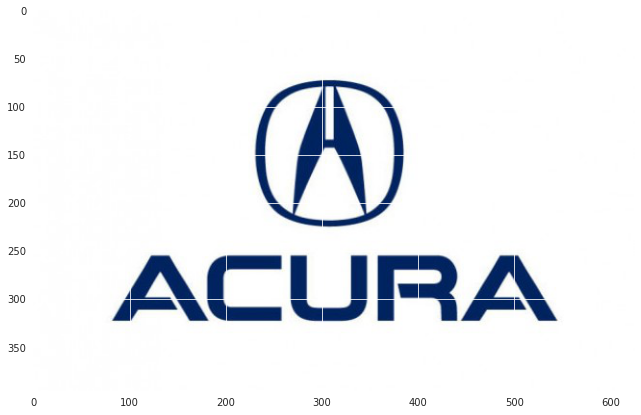

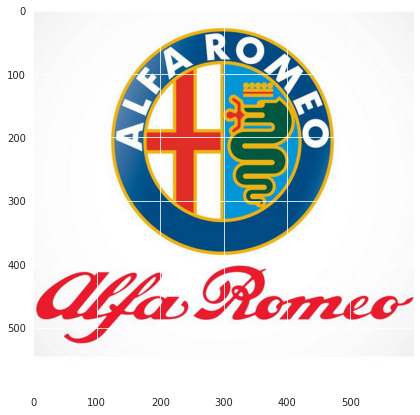

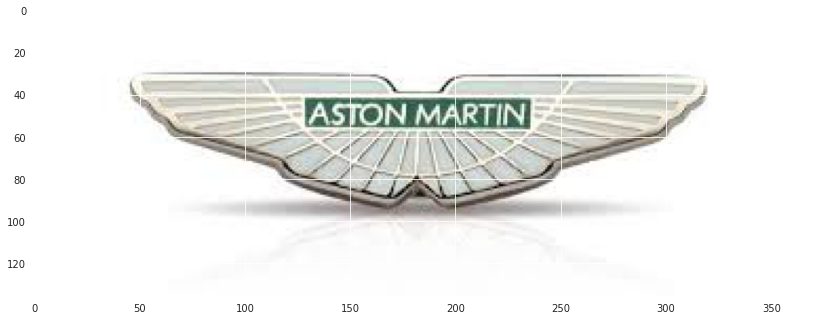

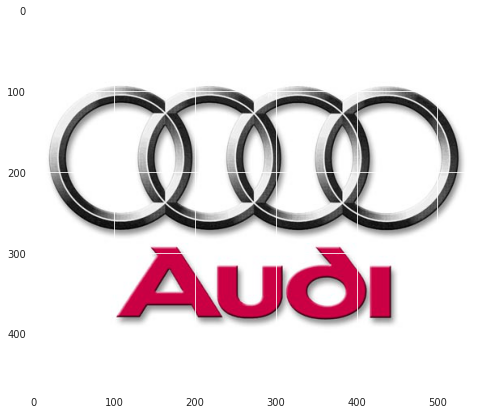

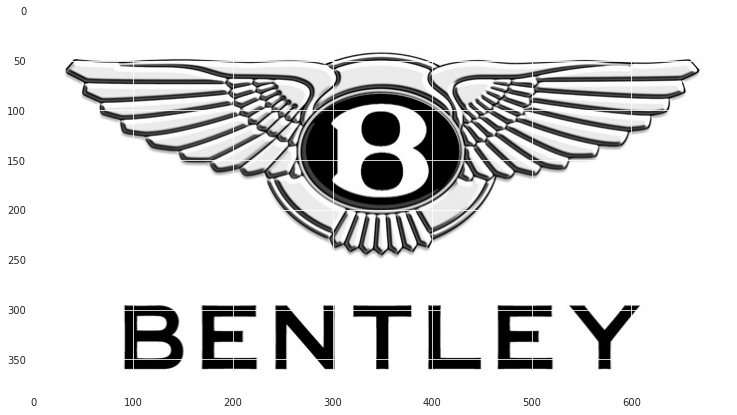

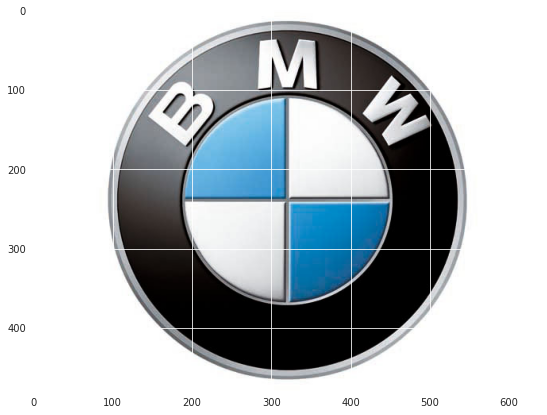

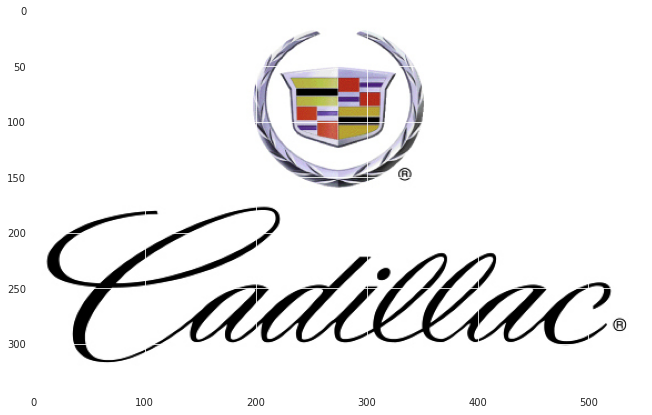

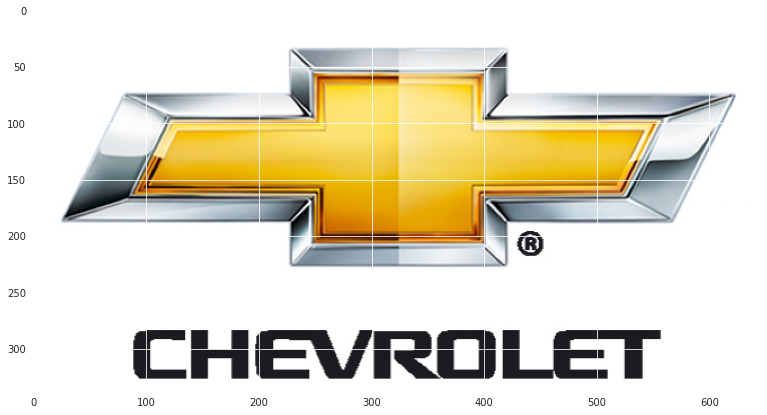

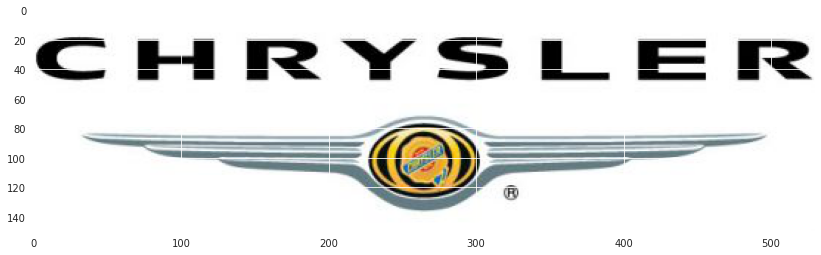

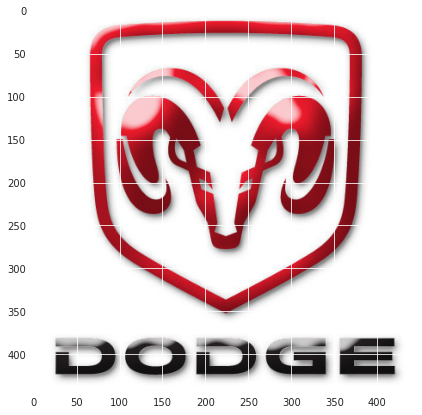

In [ ]:
for i in listID:
  plt.figure(figsize=(14,7))
  plt.imshow(Image.open(path+i))
  plt.show()

In [ ]:
#Создаем класс для собственных данных, наследуя свойства стандартного датасета
class CustomDataset(data.Dataset):
  #Переопределяем функции класса
  def __init__(self, listID, labels, path, transforms=None):
    self.listID = listID #список имен каждого экземпляра
    self.labels = labels #labels для yTrain
    self.transforms = transforms #для преобразования
    self.path = path #путь к данным

  def __getitem__(self, index): 
    #Открываем папку с данными (можно исп numpy.fromfile, PIL.Image.open)
    ID = self.listID[index] #итерируем по каждому элементу
    image = Image.open(path+ID) #извлекаем картинку по его ID

    #если transforms заполнено
    if self.transforms:
      image = self.transforms(image) #применяем transforms к картинке
      image = image.view(-1,32*32) #вытягиваю в одномерный тензор
    trainX = image #Наше изображение будет xTrain
    trainY = self.labels[index]


    return trainX, trainY

  def __len__(self):
    #ОБщий размер датасета
    return len(listID)

In [ ]:
#Трансформация изображения
transform = transforms.Compose([
                                transforms.RandomResizedCrop((32,32)), #урезаем размер изображения до 32 на 32
                                transforms.RandomVerticalFlip(), #поворот изображения на 180 градусов
                                transforms.Grayscale(), #возвращает один канал из трех, значит чернобелое изображение
                                transforms.ToTensor() #перевод в тензор pytorch
])

In [ ]:
#Создаем собственный датасет
my_Dataset = CustomDataset(listID, labels, path, transform)

In [ ]:
#На основе нашего датасета делаем генератор
trainLoader = torch.utils.data.DataLoader(dataset=my_Dataset,                                          
                                          batch_size = 2,
                                          shuffle=True)

In [ ]:
#Посмотрим на нащу выборку
dataiter = iter(trainLoader)
trainX, trainY = dataiter.next()
trainX.shape

torch.Size([2, 1, 1024])

In [ ]:
inputSize = 1024
numClasses = 10
numEpochs = 15
learningRate = 0.001
hidden = 200

In [ ]:
#Архитектура модели
#Создаем класс
class Classification(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__() #наследует все свойства и добавляем свои
    self.layer1 = nn.Linear(input_size, hidden_size) #первый линейный слой
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_size, num_classes)
    self.softmax = nn.Softmax(dim=1)

  #Прописываем последовательность выполнения архитектуры
  def forward(self,x):
    out = self.layer1(x) #выход 1 слоя
    out = self.relu(out) #примменяем функцию активации релу
    out = self.layer2(out) #передаем во второй слой
    out = self.softmax(out) #применяем функцию активации softmax
    return out


#Создаем модель
my_model = Classification(inputSize, hidden, numClasses)

In [ ]:
#Размер данных
trainX.shape

torch.Size([2, 1, 1024])

In [ ]:
#Функция ошибки и оптимизатор
criterion = nn.NLLLoss() #функция ошибки CTCLoss
optimizer = torch.optim.Adadelta(my_model.parameters(), lr=learningRate) #Оптимизатор  Adadelta
losses = [] #сюда будет добавляться ошибки, список будем использовать для построения графика
my_model.train() #перевод модели в режим обучения


Classification(
  (layer1): Linear(in_features=1024, out_features=200, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Эпоха: [1/15], Ошибка: 2.3737


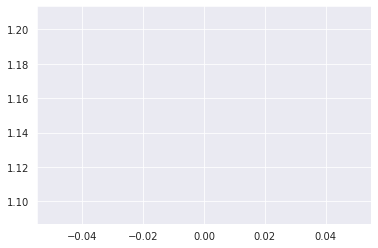

Эпоха: [2/15], Ошибка: 2.2020


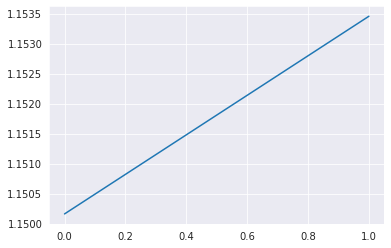

Эпоха: [3/15], Ошибка: 2.2101


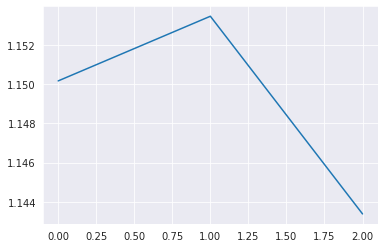

Эпоха: [4/15], Ошибка: 2.4633


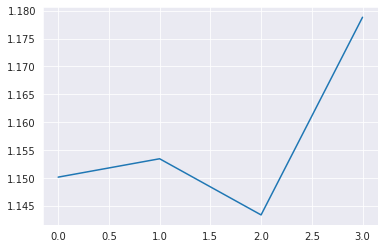

Эпоха: [5/15], Ошибка: 2.2225


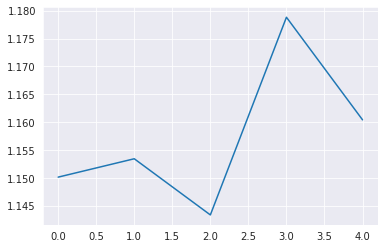

Эпоха: [6/15], Ошибка: 2.4620


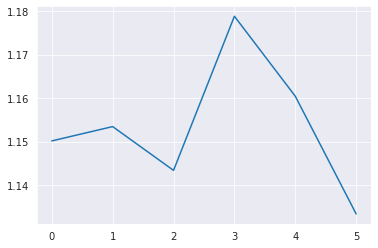

Эпоха: [7/15], Ошибка: 2.2420


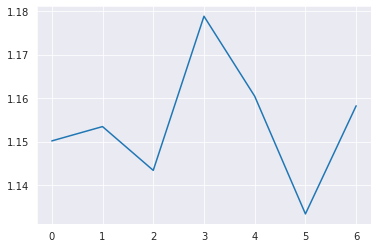

Эпоха: [8/15], Ошибка: 2.1509


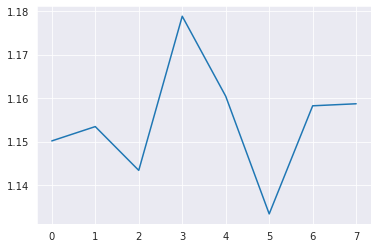

Эпоха: [9/15], Ошибка: 2.2544


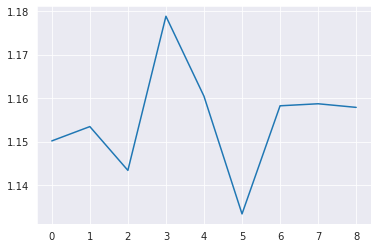

Эпоха: [10/15], Ошибка: 2.1493


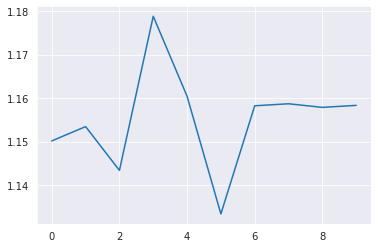

Эпоха: [11/15], Ошибка: 2.2964


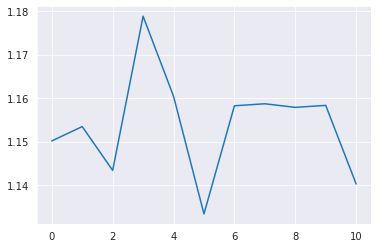

Эпоха: [12/15], Ошибка: 2.1245


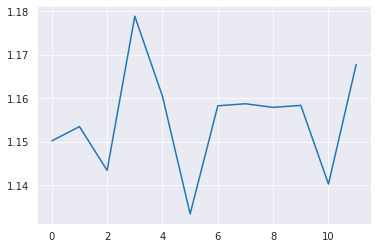

Эпоха: [13/15], Ошибка: 2.4386


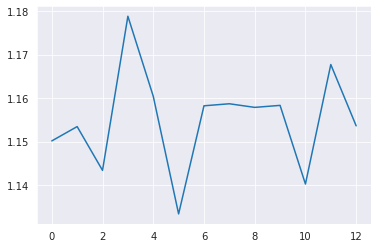

Эпоха: [14/15], Ошибка: 2.3544


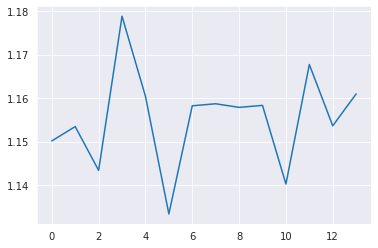

Эпоха: [15/15], Ошибка: 2.3109


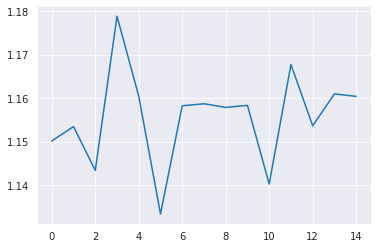

In [ ]:
#Обучение модели


for epoch in range(numEpochs):
  lossTot = 0 #потери в совокупности

  for i, (xTrain, yTrain) in enumerate(trainLoader):
    xTrain = xTrain.view(-1,32*32)
    optimizer.zero_grad() #Обнуляем градиент
    outputs = my_model(xTrain) #здесь наше предсказание
    loss = criterion(outputs.log(), yTrain) #считаем ошибку
    loss.backward() #обратное распространение:  x.grad += dloss/dx для всех параметров х
    lossTot += loss.detach().data #инкремент ошибки 
    optimizer.step() #следующий шаг спуска

  losses.append(lossTot/len(my_Dataset)) #вычисляем среднюю ошибку
  print('Эпоха: [%d/%d], Ошибка: %.4f' % (epoch+1, numEpochs, loss))
  plt.plot(losses) #График
  plt.show()


Mодель автокодировщика для любой из баз, представленных в torchvision

In [ ]:
input_size = 784 #входной размер картинок 28*28=784
num_clases = 10 #количество классов цифр
num_epoch = 10 #количество эпох
learning_rate = 0.001
hidden_size = 500 #количество скрытых нейронов

In [ ]:
#Загружаем данные

batch_size = 100

#Обучающая выборка
train_Dataset = dsets.MNIST(root='./data',
                            train = True,
                            transform = transforms.ToTensor(),
                            download = True)

test_Dataset = dsets.MNIST(root='./data',
                           train = False,
                           transform = transforms.ToTensor())


#Подготовка данных для сети
train_loader = torch.utils.data.DataLoader(dataset=train_Dataset, #Датасет обучающий
                                           batch_size = batch_size,
                                           shuffle = True)#Перемешивание


test_loader = torch.utils.data.DataLoader(dataset=test_Dataset,
                                          batch_size = batch_size,
                                          shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
#Структура выборки
dataIter = iter(train_loader) #Просмотрим обучающую выборку
train_x,_ = dataIter.next() #присваиваем текущий батч

In [ ]:
train_x.size(0)
#torchvision.utils.save_image(Variable(train_x).data.cpu(), './data/real_images.png')

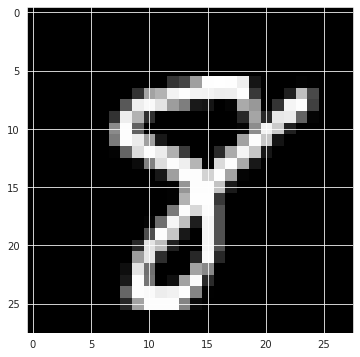

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(train_x[45,0], cmap='gray')
plt.show()

In [ ]:
#функция размещения на видеокарту наши данные
def on_cuda(x):
  if torch.cuda.is_available():
    x = x.cuda()
  return Variable(x)

In [ ]:
#Модель автокодировщика
class Autoencoder(nn.Module):
  def __init__(self, in_dim, h_dim):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential( #создаем слой энкодер
        nn.Linear(in_dim, h_dim), #аналог Dense слоя, здесь мы сжимаем данные
        nn.ReLU()  #функция активации
    )
    
    self.decoder = nn.Sequential( #создаем слой Декодер
        nn.Linear(h_dim, in_dim), #разжимаем обратно данные до входного размера
        nn.Sigmoid() #функция активации
    )

  def forward(self, x):
    out = self.encoder(x)
    out = self.decoder(out)

    return out


ae = Autoencoder(input_size, hidden_size)


In [ ]:
#Размещаем нащу сеть на видеокарту
if torch.cuda.is_available():
  ae = ae.cuda()

In [ ]:
#Функция ошибки и оптимизатор
criterion = nn.MSELoss() #Среднеквадратичная ошибка
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate) #Оптимайзер Adam
history = []
ae.train()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

Эпоха: [1/10], Шаг: [100/600], Ошибка:  0.0363
Эпоха: [1/10], Шаг: [200/600], Ошибка:  0.0225
Эпоха: [1/10], Шаг: [300/600], Ошибка:  0.0152
Эпоха: [1/10], Шаг: [400/600], Ошибка:  0.0110
Эпоха: [1/10], Шаг: [500/600], Ошибка:  0.0088
Эпоха: [1/10], Шаг: [600/600], Ошибка:  0.0064
Эпоха: [2/10], Шаг: [100/600], Ошибка:  0.0058
Эпоха: [2/10], Шаг: [200/600], Ошибка:  0.0051
Эпоха: [2/10], Шаг: [300/600], Ошибка:  0.0050
Эпоха: [2/10], Шаг: [400/600], Ошибка:  0.0039
Эпоха: [2/10], Шаг: [500/600], Ошибка:  0.0038
Эпоха: [2/10], Шаг: [600/600], Ошибка:  0.0031
Эпоха: [3/10], Шаг: [100/600], Ошибка:  0.0031
Эпоха: [3/10], Шаг: [200/600], Ошибка:  0.0033
Эпоха: [3/10], Шаг: [300/600], Ошибка:  0.0030
Эпоха: [3/10], Шаг: [400/600], Ошибка:  0.0027
Эпоха: [3/10], Шаг: [500/600], Ошибка:  0.0026
Эпоха: [3/10], Шаг: [600/600], Ошибка:  0.0024
Эпоха: [4/10], Шаг: [100/600], Ошибка:  0.0025
Эпоха: [4/10], Шаг: [200/600], Ошибка:  0.0021
Эпоха: [4/10], Шаг: [300/600], Ошибка:  0.0021
Эпоха: [4/10]

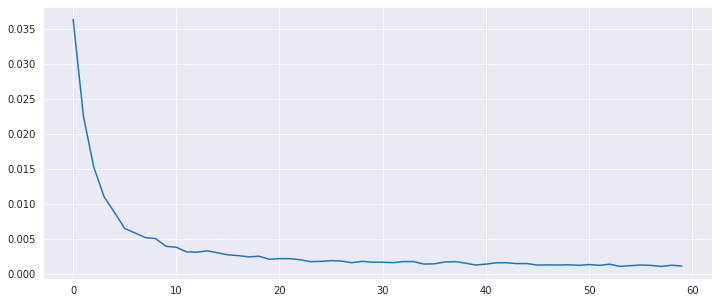

Время обработки:  13


In [ ]:
for epoch in range(num_epoch):
  lossTot = 0 #потери в совокупности
  curTime = time.time()
  for i, (images,_) in enumerate(train_loader): #так как это автокодировщик то yTrue нет
    images = on_cuda(images.view(images.size(0),28*28))
    #images = images.view(-1,28*28).cuda()
    #labels = labels.cuda()
    optimizer.zero_grad()
    out = ae(images)
    loss = criterion(out, images)#здесь сравниваем предсказаное изображение с входяшим, а не с yTrue
     
    loss.backward() #считаем частные произоводные или градиенты, обратное распространение
    optimizer.step() #изменяем веса
    
    if (i +1) % 100 == 0:
      print('Эпоха: [%d/%d], Шаг: [%d/%d], Ошибка:  %.4f'
        % (epoch+1, num_epoch, i+1, len(train_Dataset)//batch_size, loss))
      history.append(loss)

plt.figure(figsize=(12,5))
plt.plot(history)
plt.show()
print('Время обработки: ',round(time.time()-curTime))

Модель показала хорошие результаты, особенно на MSE.

In [ ]:
ae.eval()
correct = 0
total = 0

In [ ]:
#Проверка результатов
for images, _ in test_loader:
  images = on_cuda(images.view(images.size(0),28*28))
  out = ae(images)
  _, predicted = torch.max(out.data, 1)
  #print(predicted)
  total += images.size(0)
  correct += (predicted.view(predicted.size(0),-1) == images.view(images.size(0),-1)).sum()

print('Точность для 10000 картинок: %d %%' % (100 * correct/total))

Точность для 10000 картинок: 0 %


In [ ]:
train_x = on_cuda(train_x.view(train_x.size(0), -1))#переносим массив на видеокарту
reconst_images = ae(train_x) #предиктим его сетью автокодировциком
reconst_images = reconst_images.view(reconst_images.size(0), 1, 28,28) #Восстановлваем изначальный размер
#torchvision.utils.save_image(reconst_images[45,0].data.cpu(), './data/reconst_images_%d.png' % (epoch+1))
reconst_images = reconst_images.detach().numpy() #Переводим из torch в numpy


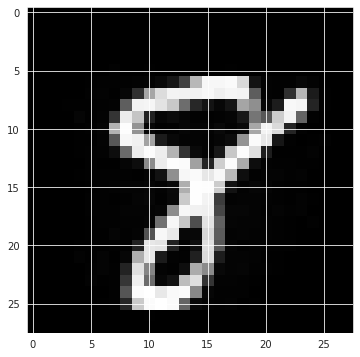

In [ ]:
#Визуализируем что распознал наш автокодировщик
plt.figure(figsize=(12,6))
plt.imshow(reconst_images[45,0],cmap='gray') #Выводим распознаное изображение, то же как выше в train_x я выводил
plt.show()